# Twitter Sentiment Analysis - Comparing Navie Bayesian VS RNN-LSTM

### **Table of Content:**

 1. [Import Preprocessed Dataset](#head-1)
 2. [Naive Bayesian Model](#head-2)  
  2.1. [Splitting the Data](#head-2-1)  
  2.2. [Training the Model](#head-2-2)  
  2.3. [Testing the Model](#head-2-3)  
  2.4. [Asserting the Model](#head-2-4)    
 3. [Deep Learning Model - LSTM](#head-3)  
  3.1. [Data Pre-processing](#head-3-1)  
&nbsp;&nbsp;&nbsp;&nbsp;3.1.1. [Word Embeddings](#head-3-1-1)  
&nbsp;&nbsp;&nbsp;&nbsp;3.1.2. [Global Vectors for Word Representation (GloVe)](#head-3-1-2)  
&nbsp;&nbsp;&nbsp;&nbsp;3.1.3. [Data Padding](#head-3-1-3)  
  3.2. [Data Transformation](#head-3-2)  
  3.3. [Building the Model](#head-3-3)  
  3.4. [Training the Model](#head-3-4)  
  3.5. [Investigating Possibilties to Improve the Model](#head-3-5)  
&nbsp;&nbsp;&nbsp;&nbsp;3.5.1. [Regularization - Dropout](#head-3-5-1)  
&nbsp;&nbsp;&nbsp;&nbsp;3.5.2. [Inspecting the Data - Unknown Words](#head-3-5-2)  
  3.6. [Predicting on Custom Data](#head-3-6)  
  3.7. [Inspecting Wrongly Predicted Data](#head-3-7)  
 4. [Saving the model](#head-4)
 5. [Further Work](#head-5)

# 1. Importing Preprocessed Dataset <a class="anchor" id="head-1"></a>

In [ ]:
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime
    
from time import time
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 6.7 ms (started: 2021-04-30 00:00:49 +00:00)


In [ ]:
local_file = "../data/cleaned.npy"
gdrive_file = "/content/drive/MyDrive/projects/twitter-sentiment-analysis/cleaned.npy"
final_data = np.load(gdrive_file, allow_pickle=True)

time: 3.01 s (started: 2021-04-30 00:00:58 +00:00)


In [23]:
len(final_data)

1600000

time: 3.62 ms (started: 2021-04-30 01:15:11 +00:00)


In [ ]:
final_data[0]

array([{'awww': True, "that's": True, 'bummer': True, 'shoulda': True, 'get': True, 'david': True, 'carr': True, 'third': True, 'day': True},
       0], dtype=object)

In [ ]:
import re, string
import nltk
nltk.download('stopwords')

# Stopwords are frequently-used words (such as “the”, “a”, “an”, “in”) that do not hold any meaning useful to extract sentiment.
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')

# A custom function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words. Including many minimally present cases would negatively impact the performance. 
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token == 'amp' or token == 'quot' or token == 'lt' or token == 'gt' or token == '½25':
        return ''
    return token

# This function will be our all-in-one noise removal function
def remove_noise(tweet_tokens):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        cleaned_token = cleaned(token.lower())
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if cleaned_token not in string.punctuation and len(cleaned_token) > 2 and cleaned_token not in STOP_WORDS:
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
time: 1.14 s (started: 2021-04-30 00:01:05 +00:00)


# 2. Naive Bayesian Model <a class="anchor" id="head-2"></a>

One of the most commonly used classification models in Natural Language Processing (NLP) is the Naive Bayesian.<br>
**Naive Bayesian** classifiers are a collection of classification algorithms based on Bayes’ Theorem. It is not a single algorithm but rather a family of algorithms where all of them make the following *naive* assumptions:
* All features are independent from each other.
* Every feature contributes equally to the output.

In our case, these two assumptions can be interpreted as:
* Each word is independent from the other words, no relation between any two words of a given sentence.
* Each word contributes equally, throughout all sentences, to the decision of our model, regardless of its relative position in the sentence.

<u>Example:</u> "This is bad" / "This is very bad" or "Such a kind person" / "This kind of chocolate is disgusting", in both cases the Naive Bayesian classifier would give the same importance for the words 'bad' and 'kind', albeit them having a stronger meaning and a different meaning respectively in first and second sentences.

Nevertheless, Naive Bayesian are widely used in NLP and they often output great results.<br>

The **Bayes' Theorem** describes the probability of an event $A$, based on prior knowledge of conditions $B$ that might be related to the event:
$P(A \mid B) = \frac{P(B \mid A)P(A)}{P(B)}$.<br>
In our case, this can be intuitively interpreted as the probability of a tweet being positive, based on prior knowledge of the words inside the input text.
In a nutshell, this probability is: the probability of the first word occuring in a positive tweet, times, the probability of the second word occuring in a positive tweet, ..., times, the probability of a tweet being positive. This can be mathematically written as: $P(A \mid B) \propto P(B_1 \mid A)\times P(B_2 \mid A)  \times  \cdot \cdot \cdot  \times  P(B_n \mid A)\times P(A)$.

## 2.1. Splitting the Data <a class="anchor" id="head-2-1"></a>

First, we need to split our data into two sets: Training and Testing sets.<br>

In [ ]:
random.Random(99).shuffle(final_data)

# I split the data as 80% train data and 20% test data
trim_index = int(len(final_data) * 0.8)

train_data = final_data[:trim_index]
test_data = final_data[trim_index:]

## 2.2. Training the Model <a class="anchor" id="head-2-2"></a>

Now it's time to train our model on our training data.

In [ ]:
from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

# Output the model accuracy on the train and test data
print('Accuracy on train data:', classify.accuracy(classifier, train_data))
print('Accuracy on test data:', classify.accuracy(classifier, test_data))

# Output the words that provide the most information about the sentiment of a tweet.
# These are words that are heavily present in one sentiment group and very rarely present in the other group.
print(classifier.show_most_informative_features(20))

Accuracy on train data: 0.9300671875
Accuracy on test data: 0.6442375
Most Informative Features
                     nks = True                1 : 0      =    102.0 : 1.0
                    dmed = True                1 : 0      =     56.7 : 1.0
                timeless = True                1 : 0      =     56.7 : 1.0
                  thanxx = True                1 : 0      =     56.7 : 1.0
                  reblip = True                1 : 0      =     56.7 : 1.0
               giveaways = True                1 : 0      =     56.7 : 1.0
                  hearty = True                1 : 0      =     52.1 : 1.0
                familyyy = True                1 : 0      =     49.1 : 1.0
                 touchin = True                1 : 0      =     49.1 : 1.0
                   vinny = True                1 : 0      =     49.1 : 1.0
               pakistani = True                1 : 0      =     41.6 : 1.0
                 paaarty = True                1 : 0      =     41.6 : 1.0
    

We achived 93% accuracy on the train set, while 64% on the testing set, which is clearly an overffiting model.

Taking a look at the 20 most informative features of the model, we can notice the high volume of positive to negative (1:0) informative features. This is very interesting as it means that positive tweets have a much more concentrated and limited vocabulary when compared to negative tweets.

## 2.3. Testing the Model <a class="anchor" id="head-2-3"></a>

Now that our classifier is built, we can have fun and test it with custom tweets!

In [ ]:
from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

time: 0 ns


In [ ]:
custom_tweet = "They screwed up, never used the app again."

custom_tokens = remove_noise(tk.tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

0
time: 16 ms


In [ ]:
custom_tweet = "I loved the show today! It was amazing and a wonderful day."

custom_tokens = remove_noise(tk.tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

1
time: 0 ns


In [ ]:
custom_tweet = "No idea"

custom_tokens = remove_noise(tk.tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

0
time: 0 ns


In [ ]:
custom_tweet = "Good"

custom_tokens = remove_noise(tk.tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

0
time: 0 ns


In [ ]:
custom_tweet = "Not good"

custom_tokens = remove_noise(tk.tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

0
time: 0 ns


In [ ]:
custom_tweet = "The reward for good work is more work!"

custom_tokens = remove_noise(tk.tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

0
time: 15 ms


It is worth mentioning one more weakness of such a model: it does not generalize well.

## 2.4. Asserting the Model <a class="anchor" id="head-2-4"></a> 

Finally, let's further assert our model by plotting the AUC and the confusion matrix of the model.

In [ ]:
from sklearn import metrics

# Storing all desired values in a list
y = [test_data[i][1] for i in range(len(test_data))]
# Storing all probabilities of having a positive sentiment in a list
probs = [classifier.prob_classify(test_data[i][0]).prob(1) for i in range(len(test_data))]

# Making sure both values a re equal
print(len(y), len(probs))

# performing the roc curve calculations
fpr, tpr, thresholds = metrics.roc_curve(y, probs)

# Printing the Area Under Curve (AUC) of the ROC curve (the closer to 1, the better)
auc = metrics.roc_auc_score(y, probs)
print('AUC: %.3f' % auc)

320000 320000
AUC: 0.830
time: 14.2 s


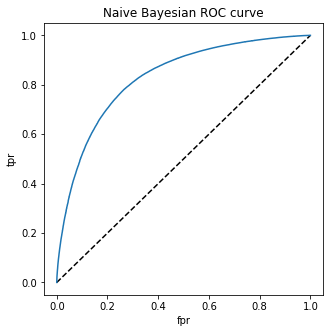

time: 281 ms


In [ ]:
# Plotting the ROC Curve
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='NB')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Naive Bayesian ROC curve')
plt.show()

In [ ]:
# Creating a confusion matrix (this specific confusion matrix function accepts numpy arrays rather than python lists)

probs = [classifier.classify(test_data[i][0]) for i in range(len(test_data))]
y = np.asarray(y)
probs = np.asarray(probs)
pd.crosstab(y, probs, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,173874,4536,178410
1,109308,32282,141590
All,283182,36818,320000


time: 14.5 s


# 3. Deep Learning Model - LSTM <a class="anchor" id="head-3"></a>

**Deep Learning** is a very rapidly growing field, that is proving to be extremely beneficial in various scenarios. One of those scenarios is the ability to process text data in a much more complex and powerful manner. In this section, I will be focusing on implementing a Deep Learning model that will successfully tackle and solve the above mentioned shortcomings of the Naive Bayes model, such as the lack of relationship between words in a sentence and the poor generalization on previously unseen data.

A **L**ong **S**hort-**T**erm **M**emory, or **LSTM**, is a type of machine learning neural networks. More specifically, it belongs to the family of **R**ecurrent **N**eural **N**etwords (**RNN**) in Deep Learning, which are specifically conceived in order to process *temporal data*. Temporal data is defined as data that is highly influenced by the order that it is presented in. This means that data coming before or after a given datum (singular for *data*) can greatly affect this datum. Text data is an example of temporal data. For example, let's consider the following sentence:

>*Jane is not very happy. She's still mad at you!*

In the above sentence, the word *not* greatly influences the meaning of the upcoming words *very happy*. Also, we used the word *she* as we are speaking about a female subject.

## 3.1. Data Pre-processing <a class="anchor" id="head-3-1"></a>

In order to feed our text data to our LSTM model, we'll have to go through several extra preprocessing steps.

Most neural networks expect *numbers* as inputs. Thus, we'll have to convert our *text* data to *numerical* data.

One way of doing so would be the following: collect all possible words in our dataset and generate a *dictionary* containing all unique words in our text corpus, then sort all of these words alphabetically and assign to each word an *index*. So for example, let's say our dictionary's length turned out to be 100,000 words. The word "a" would be assigned the index 0, the word "aaron" would be assigned the index 1, and so on, until we reach the last word in our dictionary, say "zulu", and assign to it the index 99,999.

It turns out that this step alone is not enough to be able to train good Deep Learning models. If you think about it, when the model reads an input #20,560 and then another input #20,561 for example, it would assume that these values are "close". However, those inputs could be the indexes of totally unrelated words, such as "cocktail" and "code", appearing right next to each  other in the sorted dictionary.

For producing more meaningful represetnation of the words, we can use word embedding techniques.

----------

### 3.1.1. Word Embeddings <a class="anchor" id="head-3-1-1"></a>

Word embeddings are basically a way for us to convert words to *representational vectors*. What I mean by this is that, instead of mapping each word to an index, we want to map each word to a vector of real numbers, representing this word.

The goal here is to be able to generate similar or close representational vectors for words that have similar meaning. For example, when feeding the words "excited" and "thrilled" to the word embedding model, we would like the model to output "close" representations for both words. Whereas if we feed the words "excited" and "Java", we would like the model to output "far" representations for both words.

### 3.1.2. Global Vectors for Word Representation (GloVe) <a class="anchor" id="head-3-1-2"></a>

For building a word embedding we can use the library GloVe, it's robust and accuate. Alternative choice is word2vec, which is also very popular.

For this step, go to: GloVe official Repository to download the Wikipedia 2014 + Gigaword 5 https://github.com/stanfordnlp/GloVe

Note: the file is fairly large (800MB ~), but this is already the smallest trained model

In [ ]:
# Defining a handy function in order to load a given glove file

def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

time: 7.7 ms (started: 2021-04-30 00:01:10 +00:00)


GloVe embeddings come in various flavors. They basically differ depending on the type of data they were trained on, the length of the vocabulary, the size of the representational vectors and so on.

We've previously downloaded GloVe vectors trained on 6 Billion tokens and having a dictionary, or *vocabulary*, size of 400,001 unique words. Then we will load the vectors that are 50-dimensional.

In [ ]:
# Loading the 50-dimensional GloVe embeddings
# This method will return three dictionaries:
# * word_to_index: a dictionary mapping from words to their indices in the vocabulary
# * index_to_word: dictionary mapping from indices to their corresponding words in the vocabulary
# * word_to_vec_map: dictionary mapping words to their GloVe vector representation
# Note that there are 400,001 words, with the valid indices ranging from 0 to 400,000

glove_local_path = '../data/glove.6B.50d.txt'
glove_gdrive_path = "/content/drive/MyDrive/projects/twitter-sentiment-analysis/glove.6B.50d.txt"
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(glove_gdrive_path)

time: 7.66 s (started: 2021-04-30 00:01:13 +00:00)


In [ ]:
word_to_index['hello']

176469

time: 15 ms


In [ ]:
word_to_vec_map['hello']

array([-0.38497 ,  0.80092 ,  0.064106, -0.28355 , -0.026759, -0.34532 ,
       -0.64253 , -0.11729 , -0.33257 ,  0.55243 , -0.087813,  0.9035  ,
        0.47102 ,  0.56657 ,  0.6985  , -0.35229 , -0.86542 ,  0.90573 ,
        0.03576 , -0.071705, -0.12327 ,  0.54923 ,  0.47005 ,  0.35572 ,
        1.2611  , -0.67581 , -0.94983 ,  0.68666 ,  0.3871  , -1.3492  ,
        0.63512 ,  0.46416 , -0.48814 ,  0.83827 , -0.9246  , -0.33722 ,
        0.53741 , -1.0616  , -0.081403, -0.67111 ,  0.30923 , -0.3923  ,
       -0.55002 , -0.68827 ,  0.58049 , -0.11626 ,  0.013139, -0.57654 ,
        0.048833,  0.67204 ])

time: 15 ms


As this word embedding only considers 400,000 unique words, it might encounter words it has never seen before.

In order to overcome such scenarios, word embeddings reserve an extra spot for "unknown" words, also denoted with the keyword **unk**.

In [ ]:
word_to_index['unk']

372307

time: 0 ns


When calculating the difference between each words, we used cosine similarity. Below is a short example of the usage of the cosine similarity in order to find correlations in the data.

We can observe that the words *cucumber* and *tomato* are highly positively similar. Whereas the words *cucumber* and *phone* are not related at all, having a close to 0 similarity measure.

> Note that the cosine similarity return values between -1 and +1, where **-1** denote completely opposite meanings, **+1** denote completely identical meanings and **0** denote totally unrelated meanings.

In [ ]:
def cosine_similarity(u, v):
    dot = np.dot(u, v)
    norm_u = np.sqrt(np.sum(u**2))
    norm_v = np.sqrt(np.sum(v**2))
    cosine_similarity = dot / (norm_u * norm_v)
    return cosine_similarity

time: 4.88 ms (started: 2021-04-30 00:01:20 +00:00)


In [ ]:
cosine_similarity(word_to_vec_map['cucumber'], word_to_vec_map['tomato'])

0.8632714714841137

time: 0 ns


In [ ]:
cosine_similarity(word_to_vec_map['cucumber'], word_to_vec_map['phone'])

-0.012485506721235948

time: 0 ns


### 3.1.3. Data Padding  <a class="anchor" id="head-3-1-3"></a>

Further in our training we would like to speed the process up by splitting data into *mini-batches*. Batch learning is basically the process of training on several examples at the same time, which greatly decreases the training time!

However, and in order to be able to utilize batch learning, keras (and similarly to most machine learning frameworks) requires all data within the same batch to have the same length or *dimension*. Whereas in our text data, each example could have a variable sentence length. In order to overcome this issue, we will go over all of our data, and calculate the length of the longest phrase (in terms of words). Then, we will 0-pad all of the data sequences so that they will all have the same *max_len* calculated.

## 3.2. Data Transformation <a class="anchor" id="head-3-2"></a>

In [ ]:
# remove label for transformation
cleaned_tokens_list = [(list(sent[0]), sent[1]) for sent in final_data]

time: 4.57 s (started: 2021-04-30 00:01:23 +00:00)


In [ ]:
cleaned_tokens_list[0]

(['awww',
  "that's",
  'bummer',
  'shoulda',
  'get',
  'david',
  'carr',
  'third',
  'day'],
 0)

time: 0 ns


In [ ]:
unks = []
UNKS = []

# This function will act as a "last resort" in order to try and find the word
# in the words embedding layer. It will basically eliminate contiguously occuring such as "looool" -> "lol"
# instances of a similar character
def cleared(word):
    res = ""
    prev = None
    for char in word:
        if char == prev: continue
        prev = char
        res += char
    return res


def sentence_to_indices(sentence_words, word_to_index, max_len, i):
    global X, Y
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            UNKS.append(w)
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
                unks.append(w)
        X[i, j] = index

        
# Here we will utilize the already computed 'cleaned_tokens_list' variable
list_len = [len(i) for i, j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)

X = np.zeros((len(cleaned_tokens_list), max_len))
Y = np.zeros((len(cleaned_tokens_list), ))

for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    sentence_to_indices(tokens, word_to_index, max_len, i)
    Y[i] = label


print(X[:5])
print(Y[:5])

max_len: 25
[[ 64416. 372307.  86732. 329918. 160419. 117721.  92607. 358030. 117875.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [373562. 372307. 373376. 143883. 356843.    868. 243978. 112844. 306709.
  321161. 361081.  52521.  77742.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [125957. 233709. 359890.  67288. 232573. 319419. 306582.  81902.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [386898.  79377. 146345. 193827. 222472. 148729.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [ 72017. 372307. 229754. 372307. 323338.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.   

In [ ]:
print(X.shape)
print(Y.shape)

(1600000, 25)
(1600000,)
time: 0 ns


## 3.3. Building the Model <a class="anchor" id="head-3-3"></a>

In [ ]:
import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split

time: 42.4 ms (started: 2021-04-30 00:01:35 +00:00)


In [ ]:
# Defining a function that will initialize and populate our embedding layer

def pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len):
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["unk"].shape[0] #50
    
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
        
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False, input_shape=(max_len,))
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

time: 6.71 ms (started: 2021-04-30 00:01:35 +00:00)


In [ ]:
# Defining a sequencial model composed of 
# 1. the embedding layer, 
# 2. a pair of Bidirectional LSTMs,
# 3. feed into a sigmoid layer that generates our desired output betwene 0 and 1.

# Note: if countering "Cannot convert a symbolic Tensor (strided_slice:0) to a numpy array"
# You can downgrade numpy with: pip install numpy==1.19.5
model = Sequential()

model.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 50)            20000100  
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 256)           183296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 20,577,893
Trainable params: 577,793
Non-trainable params: 20,000,100
_________________________________________________________________
time: 1.87 s (started: 2021-04-30 00:01:35 +00:00)


In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

time: 15.5 ms (started: 2021-04-30 00:01:37 +00:00)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

time: 892 ms (started: 2021-04-30 00:01:39 +00:00)


In [ ]:
len(X_train)

1280000

time: 0 ns


In [ ]:
len(X_test)

320000

time: 0 ns


## 3.4. Training the Model <a class="anchor" id="head-5-4"></a>

In [ ]:
# test if gpu exist on google colab
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0
time: 17.1 ms (started: 2021-04-30 00:01:42 +00:00)


In [24]:
# Setting a batch size of 20 and training our model for 20 epochs
# It's highly recommended to train RNN on GPU, this could save more than 30 times of the training time
if device_name != '/device:GPU:0':
  model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True)
else: 
  with tf.device('/device:GPU:0'):
    model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True)

Epoch 1/20
10000/10000 [==============================] - 127s 13ms/step - loss: 0.2461 - accuracy: 0.8922 - val_loss: 0.7124 - val_accuracy: 0.7487
Epoch 2/20
10000/10000 [==============================] - 128s 13ms/step - loss: 0.2423 - accuracy: 0.8945 - val_loss: 0.7268 - val_accuracy: 0.7477
Epoch 3/20
10000/10000 [==============================] - 129s 13ms/step - loss: 0.2383 - accuracy: 0.8962 - val_loss: 0.7315 - val_accuracy: 0.7457
Epoch 4/20
10000/10000 [==============================] - 129s 13ms/step - loss: 0.2351 - accuracy: 0.8974 - val_loss: 0.7426 - val_accuracy: 0.7466
Epoch 5/20
10000/10000 [==============================] - 127s 13ms/step - loss: 0.2317 - accuracy: 0.8994 - val_loss: 0.7573 - val_accuracy: 0.7453
Epoch 6/20
10000/10000 [==============================] - 128s 13ms/step - loss: 0.2292 - accuracy: 0.9004 - val_loss: 0.7484 - val_accuracy: 0.7454
Epoch 7/20
10000/10000 [==============================] - 127s 13ms/step - loss: 0.2265 - accuracy: 0.9017

In [25]:
# Defnining a handy function in order to plot various models accuracy and loss progress

def plot_acc_loss(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

time: 11 ms (started: 2021-04-30 01:58:24 +00:00)


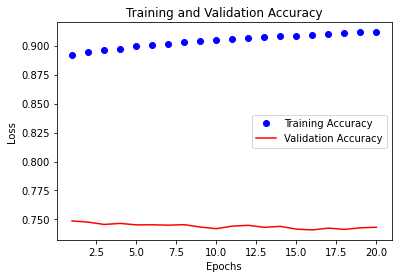

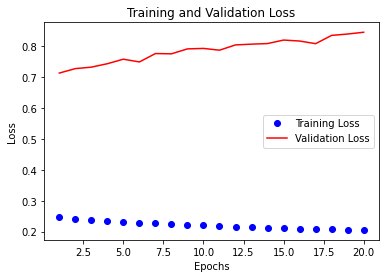

time: 327 ms (started: 2021-04-30 01:58:27 +00:00)


In [26]:
# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)

The training accuracy is sky-rocketing, exceeding **91%** after 20 epochs. However, the validation accuracy experienced a consistently gradual decrease from **74%**. We can conclude this model havs very high variance and low bias, which is clearly "over-fitting".

## 3.5. Investigating Possibilties to Improve the Model <a class="anchor" id="head-3-5"></a>

Several directions could be undertaken at this stage in order to improve our model's performance. And the most promising direction to firstly look into is to introduce some kind of regularization in our model in order to try to reduce the clearly apparent over-fitting problem our model is facing.

### 3.5.1. Regularization - Dropout <a class="anchor" id="head-3-5-1"></a>

**Regularization** is the process of preventing a model from over-fitting the training data. You can conceptualize regularization as being a tool we use in order to render our model less sensible to every detail, and possibly outliers, in the training data. This should allow the model to better generalize and have a better performance on the validation data, or any data it wasn't trained on.

**Dropout** is one of the many regularization techniques, and also one of the simplest to implement and most commonly used. Basically, what dropout does is that it randomly eliminates several (based on a parametrized percentage rate) neurons connections in the network, rendering the model less complex, and forcing the model to only look at part of a given example. The random elimination of connections in the model is repeated randomly for each example training data.


For example, let's consider the following sentences, with a dropout layer with a rate of 0.5 (50% of connections will be eliminated): 

> "Another kind of regularization can be directly applied to the cost function"
>
> "This is my first ever notebook. Hope you're enjoying it so far!"

The output of the dropout layer could look like the following:

> "kind of regularization be to function"
>
> "This my notebook. you enjoying it far!"

Thus, the model will only have information on a part of the input example, and should be able to escape over-fitting particular characteristics of the training data.

### Model Building - Dropout

In [27]:
keras.backend.clear_session()

model_dropout = Sequential()

model_dropout.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
model_dropout.add(Dropout(rate=0.4))
model_dropout.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_dropout.add(Dropout(rate=0.4))
model_dropout.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_dropout.add(Dense(units=1, activation='sigmoid'))

model_dropout.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 50)            20000100  
_________________________________________________________________
dropout (Dropout)            (None, 25, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 256)           183296    
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 20,577,893
Trainable params: 577,793
Non-trainable params: 20,000,100
______________________________________

In [28]:
model_dropout.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

time: 11.8 ms (started: 2021-04-30 02:00:48 +00:00)


### Model Training - Dropout

In [29]:
if device_name != '/device:GPU:0':
  model_dropout.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True)
else: 
  with tf.device('/device:GPU:0'):
    model_dropout.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True)

Epoch 1/20
10000/10000 [==============================] - 138s 13ms/step - loss: 0.5867 - accuracy: 0.6822 - val_loss: 0.5046 - val_accuracy: 0.7491
Epoch 2/20
10000/10000 [==============================] - 132s 13ms/step - loss: 0.5346 - accuracy: 0.7258 - val_loss: 0.4926 - val_accuracy: 0.7581
Epoch 3/20
10000/10000 [==============================] - 132s 13ms/step - loss: 0.5206 - accuracy: 0.7358 - val_loss: 0.4836 - val_accuracy: 0.7644
Epoch 4/20
10000/10000 [==============================] - 131s 13ms/step - loss: 0.5140 - accuracy: 0.7401 - val_loss: 0.4792 - val_accuracy: 0.7667
Epoch 5/20
10000/10000 [==============================] - 130s 13ms/step - loss: 0.5078 - accuracy: 0.7454 - val_loss: 0.4743 - val_accuracy: 0.7695
Epoch 6/20
10000/10000 [==============================] - 132s 13ms/step - loss: 0.5049 - accuracy: 0.7477 - val_loss: 0.4752 - val_accuracy: 0.7697
Epoch 7/20
10000/10000 [==============================] - 132s 13ms/step - loss: 0.5021 - accuracy: 0.7494

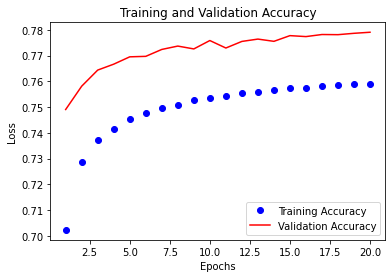

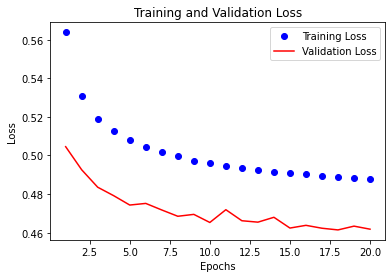

time: 303 ms (started: 2021-04-30 02:44:28 +00:00)


In [30]:
plot_acc_loss(model_dropout.history)

We can clearly see the effects of adding dropout layers on the training progress. The training accuracy is progressing at a much slower pace than it previously did. Nevertheless, the validation accuracy is steadily increasing, reaching 77%.

Let's keep on training the model for 20 more epochs.

In [31]:
if device_name != '/device:GPU:0':
  model_dropout.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True)
else: 
  with tf.device('/device:GPU:0'):
    model_dropout.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True)

Epoch 1/20
10000/10000 [==============================] - 129s 13ms/step - loss: 0.4872 - accuracy: 0.7597 - val_loss: 0.4621 - val_accuracy: 0.7784
Epoch 2/20
10000/10000 [==============================] - 129s 13ms/step - loss: 0.4871 - accuracy: 0.7597 - val_loss: 0.4614 - val_accuracy: 0.7785
Epoch 3/20
10000/10000 [==============================] - 128s 13ms/step - loss: 0.4864 - accuracy: 0.7601 - val_loss: 0.4610 - val_accuracy: 0.7780
Epoch 4/20
10000/10000 [==============================] - 129s 13ms/step - loss: 0.4859 - accuracy: 0.7605 - val_loss: 0.4599 - val_accuracy: 0.7789
Epoch 5/20
10000/10000 [==============================] - 129s 13ms/step - loss: 0.4854 - accuracy: 0.7611 - val_loss: 0.4657 - val_accuracy: 0.7771
Epoch 6/20
10000/10000 [==============================] - 127s 13ms/step - loss: 0.4852 - accuracy: 0.7614 - val_loss: 0.4590 - val_accuracy: 0.7797
Epoch 7/20
10000/10000 [==============================] - 128s 13ms/step - loss: 0.4851 - accuracy: 0.7613

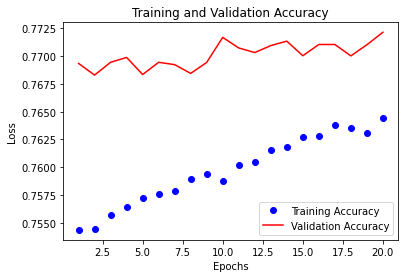

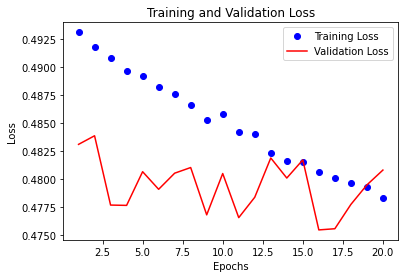

In [ ]:
plot_acc_loss(model_dropout.history)

We can observe that the accuracy has plateaued, reaching its best validation value of **77.2%**.

Thus, we can conclude that the regularization process did not really help us in our case. A tiny **0.5%** improvement was observed after adding dropout to the model.

This leads us to the second direction to investigate in order to improve our model: **data**.

### 3.5.2. Inspecting the Data - Unknown Words <a class="anchor" id="head-3-5-2"></a>

As explained earlier, whenever a word is not included in the words embedding mapping, it is referred to as an unknown word, or *unk*. Let's count the number of words that are being flagged as unknowns in our data. 

In [32]:
unk = word_to_index['unk']

n_unk_words = 0

for x in X:
    for y in x:
        if y == unk:
            n_unk_words += 1

n_unk_words

792877

time: 15.2 s (started: 2021-04-30 04:08:54 +00:00)


800K unknown words are kind of a lot. In fact, after counting the total number of words in our data, this equates to ~7% of all words. 

In [33]:
len(unks)

792873

time: 6.92 ms (started: 2021-04-30 04:10:26 +00:00)


In [34]:
len(UNKS)

912065

time: 4.64 ms (started: 2021-04-30 04:10:27 +00:00)


In the function `sentence_to_indices`, we have incorporated a "last resort" function `cleared`, which eliminates contiguous similar characters.

Let's investigate some of the most commonly occuring unknowns words in our data.

In [35]:
from collections import Counter
Counter(unks).most_common(50)

[("i'm", 122237),
 ("can't", 44971),
 ("i'l", 25069),
 ("that's", 21660),
 ("i've", 19508),
 ("he's", 7943),
 ("i'd", 7589),
 ('hahaha', 7190),
 ("we're", 6409),
 ("there's", 5874),
 ("what's", 5510),
 ("they're", 4989),
 ('lmao', 4696),
 ("we'l", 3573),
 ("let's", 3215),
 ('#folowfriday', 2616),
 ('bday', 2608),
 ('idk', 2549),
 ("it'l", 2243),
 ('. .', 2240),
 ('hahah', 2046),
 ("mother's", 1910),
 ('#fb', 1786),
 ("how's", 1705),
 ('. . .', 1642),
 ('hahahaha', 1601),
 ("who's", 1469),
 (":'(", 1407),
 ('thanx', 1364),
 ('tweps', 1311),
 ("ain't", 1276),
 ("y'al", 1214),
 ("we've", 1211),
 (';-)', 1092),
 ('coky', 1090),
 ('hehehe', 1079),
 ("where's", 1056),
 ('awh', 1043),
 ("today's", 1015),
 ("here's", 999),
 ('2morow', 970),
 ('ahaha', 927),
 ('#squarespace', 925),
 ("mom's", 874),
 ('urgh', 839),
 ('b-day', 835),
 ('w.tweterader.com', 830),
 ('sux', 810),
 ('tomorow', 804),
 ("father's", 798)]

time: 157 ms (started: 2021-04-30 04:15:43 +00:00)


We can observe that most of the unknown words are very common words, however the word embeddings layer does not support quotes. For example, if you try to get the index of the word "i'm", you'll be prompted with a key error, whereas the word "im" is available as a valid key. Other words, such as "idk", "lmao" or "b-day" reminds us that our data comes from twitter, and we'll have to individually handle each of these words such that our words embedding layer recognise them.

### Further data cleaning

Gathering insights from the above output, and from manually skimming through the data, the `remove_noise` function has been redefined as follows:

In [37]:
# A custom function defined in order to fine-tune the cleaning of the input text.
# This function is being "upgraded" such that it performs a more thourough cleaning of the data
# in order to better fit our words embedding layer
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow' or token == '2moro':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token in ['hahah', 'hahaha', 'hahahaha']:
        return 'haha'
    if token == "mother's":
        return "mother"
    if token == "mom's":
        return "mom"
    if token == "dad's":
        return "dad"
    if token == 'bday' or token == 'b-day':
        return 'birthday'
    if token in ["i'm", "don't", "can't", "couldn't", "aren't", "wouldn't", "isn't", "didn't", "hadn't",
                 "doesn't", "won't", "haven't", "wasn't", "hasn't", "shouldn't", "ain't", "they've"]:
        return token.replace("'", "")
    if token in ['lmao', 'lolz', 'rofl']:
        return 'lol'
    if token == '<3':
        return 'love'
    if token == 'thanx' or token == 'thnx':
        return 'thanks'
    if token == 'goood':
        return 'good'
    if token in ['amp', 'quot', 'lt', 'gt', '½25', '..', '. .', '. . .']:
        return ''
    return token


# This function will be our all-in-one noise removal function
def remove_noise(tweet_tokens):

    cleaned_tokens = []

    for token in tweet_tokens:
        # Eliminating the token if it is a link
        token = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        
        cleaned_token = cleaned(token.lower())
        
        if cleaned_token == "idk":
            cleaned_tokens.append('i')
            cleaned_tokens.append('dont')
            cleaned_tokens.append('know')
            continue
        if cleaned_token == "i'll":
            cleaned_tokens.append('i')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "you'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "we'll":
            cleaned_tokens.append('we')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it'll":
            cleaned_tokens.append('it')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it's":
            cleaned_tokens.append('it')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i've":
            cleaned_tokens.append('i')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you've":
            cleaned_tokens.append('you')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "we've":
            cleaned_tokens.append('we')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "they've":
            cleaned_tokens.append('they')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you're":
            cleaned_tokens.append('you')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "we're":
            cleaned_tokens.append('we')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "they're":
            cleaned_tokens.append('they')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "let's":
            cleaned_tokens.append('let')
            cleaned_tokens.append('us')
            continue
        if cleaned_token == "she's":
            cleaned_tokens.append('she')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "he's":
            cleaned_tokens.append('he')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "that's":
            cleaned_tokens.append('that')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i'd":
            cleaned_tokens.append('i')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "you'd":
            cleaned_tokens.append('you')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "there's":
            cleaned_tokens.append('there')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "what's":
            cleaned_tokens.append('what')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "how's":
            cleaned_tokens.append('how')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "who's":
            cleaned_tokens.append('who')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "y'all" or cleaned_token == "ya'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('all')
            continue

        if cleaned_token.strip() and cleaned_token not in string.punctuation: 
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens


# Prevewing the remove_noise() output
print(remove_noise(final_data[0][0]))

['awww', 'that', 'is', 'bummer', 'shoulda', 'get', 'david', 'carr', 'third', 'day']
time: 183 ms (started: 2021-04-30 04:18:18 +00:00)


Now let's re-compute our X and Y arrays according to the newly defined `remove_noise` function.

In [39]:
unks = []
UNKS = []

def cleared(word):
    res = ""
    prev = None
    for char in word:
        if char == prev: continue
        prev = char
        res += char
    return res

def sentence_to_indices(sentence_words, word_to_index, max_len, i):
    global X, Y
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            UNKS.append(w)
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
                unks.append(w)
        X[i, j] = index

cleaned_tokens_list = []

# Removing noise from all the data, using the newly defined function
for tokens, label in final_data:
    x = remove_noise(tokens)
    if x:
        cleaned_tokens_list.append((x, label))

list_len = [len(i) for i, j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)


X = np.zeros((len(cleaned_tokens_list), max_len))
Y = np.zeros((len(cleaned_tokens_list), ))


for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    sentence_to_indices(tokens, word_to_index, max_len, i)
    Y[i] = label
    

print(X[:5])
print(Y[:5])

max_len: 25
[[ 64416. 357213. 192974.  86732. 329918. 160419. 117721.  92607. 358030.
  117875.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [373562.  91042. 373376. 143883. 356843.    868. 243978. 112844. 306709.
  321161. 361081.  52521.  77742.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [125957. 233709. 359890.  67288. 232573. 319419. 306582.  81902.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [386898.  79377. 146345. 193827. 222472. 148729.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [ 72017. 187632. 229754.  91042. 323338.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.   

Great, let's take a look at the progress accomplished:

In [40]:
unk = word_to_index['unk']

n_unk_words = 0

for x in X:
    for y in x:
        if y == unk:
            n_unk_words += 1

n_unk_words

469651

time: 15.3 s (started: 2021-04-30 04:20:53 +00:00)


That's amazing! We've managed to bring down the number of unknown words from 800K to 470K!

In [41]:
from collections import Counter
Counter(unks).most_common(50)

[('#folowfriday', 2616),
 ('#fb', 1786),
 ('. .', 1486),
 (":'(", 1407),
 ('tweps', 1311),
 (';-)', 1092),
 ('coky', 1090),
 ('hehehe', 1079),
 ("where's", 1056),
 ('awh', 1043),
 ("today's", 1015),
 ("here's", 999),
 ('2morow', 970),
 ('ahaha', 927),
 ('#squarespace', 925),
 ('urgh', 839),
 ('sux', 810),
 ('tomorow', 804),
 ("father's", 798),
 ("they'l", 793),
 ("he'l", 785),
 ('tmrw', 739),
 ('yey', 702),
 ('retwet', 679),
 ('<-', 653),
 ('woho', 639),
 ('probs', 633),
 ('bleh', 630),
 ('hayfever', 627),
 ('bestie', 626),
 ("she'l", 613),
 ('theyve', 602),
 ('->', 593),
 ('awsome', 588),
 ("everyone's", 583),
 ('omfg', 582),
 ("friend's", 575),
 ('proly', 573),
 ('hahahah', 565),
 ('damnit', 526),
 ('#iranelection', 514),
 ("would've", 504),
 (':-d', 504),
 ('twiterverse', 498),
 ("g'night", 494),
 ("it'd", 467),
 ('tbh', 443),
 ("tomorow's", 440),
 ('ahah', 425),
 ('lvat', 423)]

time: 117 ms (started: 2021-04-30 04:21:35 +00:00)


Further optimizing the number of unknown words at this point would not be the best use of our time. As now we are left with a big number of minimally occuring words in the data. Thus, spending more time cleaning the data would result in a very little return on investment.

Now, let's try to train our model on the newly generated *cleaner* data!

### Model Training - Cleaner Data

In [42]:
keras.backend.clear_session()

model_clean_data = Sequential()

model_clean_data.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
model_clean_data.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_clean_data.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_clean_data.add(Dense(units=1, activation='sigmoid'))

model_clean_data.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 50)            20000100  
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 256)           183296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 20,577,893
Trainable params: 577,793
Non-trainable params: 20,000,100
_________________________________________________________________
time: 1.65 s (started: 2021-04-30 04:21:54 +00:00)


In [43]:
model_clean_data.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

time: 13.2 ms (started: 2021-04-30 04:22:18 +00:00)


In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

time: 771 ms (started: 2021-04-30 04:22:19 +00:00)


In [45]:
len(X_train)

1272924

time: 6.39 ms (started: 2021-04-30 04:22:21 +00:00)


In [46]:
len(X_test)

318232

time: 4.32 ms (started: 2021-04-30 04:22:22 +00:00)


In [47]:
if device_name != '/device:GPU:0':
  model_clean_data.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True)
else: 
  with tf.device('/device:GPU:0'):
    model_clean_data.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True)

Epoch 1/20
9945/9945 [==============================] - 138s 13ms/step - loss: 0.5349 - accuracy: 0.7252 - val_loss: 0.4731 - val_accuracy: 0.7715
Epoch 2/20
9945/9945 [==============================] - 133s 13ms/step - loss: 0.4641 - accuracy: 0.7769 - val_loss: 0.4592 - val_accuracy: 0.7801
Epoch 3/20
9945/9945 [==============================] - 134s 13ms/step - loss: 0.4438 - accuracy: 0.7896 - val_loss: 0.4521 - val_accuracy: 0.7854
Epoch 4/20
9945/9945 [==============================] - 135s 14ms/step - loss: 0.4282 - accuracy: 0.7982 - val_loss: 0.4529 - val_accuracy: 0.7854
Epoch 5/20
9945/9945 [==============================] - 134s 13ms/step - loss: 0.4134 - accuracy: 0.8067 - val_loss: 0.4561 - val_accuracy: 0.7852
Epoch 6/20
9945/9945 [==============================] - 134s 14ms/step - loss: 0.3963 - accuracy: 0.8170 - val_loss: 0.4614 - val_accuracy: 0.7836
Epoch 7/20
9945/9945 [==============================] - 134s 13ms/step - loss: 0.3792 - accuracy: 0.8258 - val_loss: 0

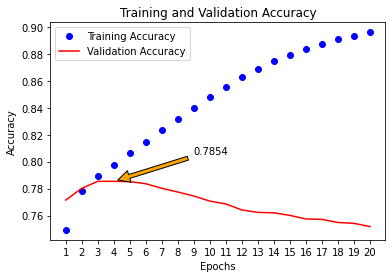

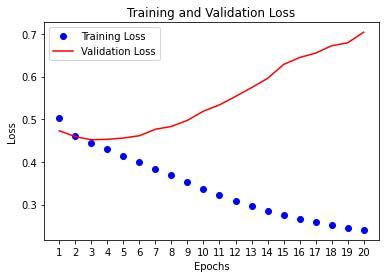

time: 388 ms (started: 2021-04-30 05:10:39 +00:00)


In [48]:
history = model_clean_data.history

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
y_arrow = max(val_acc)
x_arrow = val_acc.index(y_arrow) + 1
plt.annotate(str(y_arrow)[:6],
             (x_arrow, y_arrow),
             xytext=(x_arrow + 5, y_arrow + .02),
             arrowprops=dict(facecolor='orange', shrink=0.05))
plt.xticks(epochs)

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
plt.show()

The model managed to reach **78.4%** validation accuracy on the 5th epoch, which consider to be an improvement.

Nonetheless, the over-fitting problem is still persistent in the model. This could be further reduced by introducing a more aggressive regularization and training the model for a much bigger number of epochs, and by also training the model on a bigger, more diverse, cleaner data.

## 3.6. Predicting on Custom Data <a class="anchor" id="head-3-6"></a>

Now let’s testing our model on some custom data.

This model will return values between 0 and 1, representing it’s confidence on whether a tweet holds a negative or a positive sentiment. The closer the value is to 0, the more confident the model is that this tweet is negative. The closer the value is to 1, the more confident the model is that this tweet is negative.


In [53]:
from nltk.tokenize import TweetTokenizer
tk = TweetTokenizer(reduce_len=True)

def sentence_to_indices(sentence_words, max_len):
    X = np.zeros((max_len))
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
        X[j] = index
    return X

def predict_custom_tweet_sentiment(custom_tweet):
    # Convert the tweet such that it can be fed to the model
    x_input = sentence_to_indices(remove_noise(tk.tokenize(custom_tweet)), max_len)
    
    # Retrun the model's prediction
    return model_clean_data.predict(np.array([x_input])).item()

time: 12.7 ms (started: 2021-04-30 05:13:26 +00:00)


In [54]:
predict_custom_tweet_sentiment("I'm happy you're here!")

0.9992701411247253

time: 1.14 s (started: 2021-04-30 05:13:28 +00:00)


In [55]:
predict_custom_tweet_sentiment("I'm not happy you're here!")

0.9953598380088806

time: 44.2 ms (started: 2021-04-30 05:13:38 +00:00)


In [56]:
predict_custom_tweet_sentiment("I disliked his attitude...")

0.20939767360687256

time: 50.5 ms (started: 2021-04-30 05:14:01 +00:00)


## 3.7. Inspecting Wrongly Predicted Data <a class="anchor" id="head-3-7"></a>

Let's take a look at some of the wrongly classified data from the model.

In [63]:
def i_to_sentence(I):
    sentence = ""
    for i in I:
        if i:
            sentence += index_to_word[int(i)] + " "
        else:
            break
    return sentence

time: 2.82 ms (started: 2021-04-30 05:17:22 +00:00)


In [64]:
C = 0

pred = model_clean_data.predict(X_test)

for i in range(len(X_test)):
    final_pred = 1 if pred[i] > 0.5 else 0
    
    if(final_pred != Y_test[i]):
        print('Expected sentiment: ' + str(int(Y_test[i])) + '. Input: ' + i_to_sentence(X_test[i]))
        C += 1
        
    if C > 100:
        break

Expected sentiment: 1. Input: headache love morning 
Expected sentiment: 0. Input: hear hour work day cool 
Expected sentiment: 0. Input: dear web host please release site purgatory provide unk unk 
Expected sentiment: 0. Input: get away mp3 garbage dont people know mp3s sound like crap 
Expected sentiment: 1. Input: frustrate want eat get fat 
Expected sentiment: 1. Input: get talk bo super unk life haha julie 
Expected sentiment: 0. Input: twitter crackberry still no-go 
Expected sentiment: 0. Input: back vacation want disney world 
Expected sentiment: 1. Input: mean 
Expected sentiment: 1. Input: whats goin unk tell something good aint follow unk active unk 
Expected sentiment: 1. Input: photobucket time yes scar unk 
Expected sentiment: 0. Input: really point watch cedric die 
Expected sentiment: 1. Input: im get unk work today stay 1am tonight 
Expected sentiment: 1. Input: im sorry feel well genesis serpent take way calvary good 
Expected sentiment: 0. Input: zombieland trailer w

Skimming through the above output, we can "understand" why the model wouldn't properly classify several examples. Some examples seem wrongly labeled in the first place, whereas some other examples are really hard to classify without further context.

So all in all, I would say that our current model is relatively robust in classifying the sentiment in a given sentence!

# 4. Saving the model <a class="anchor" id="head-4"></a>

In [65]:
model_clean_data.save("best_lstm")

INFO:tensorflow:Assets written to: best_lstm/assets


INFO:tensorflow:Assets written to: best_lstm/assets


time: 19.4 s (started: 2021-04-30 05:19:56 +00:00)


# 5. Further Work <a class="anchor" id="head-5"></a>

* Further data cleaning and relabelling. As the data origin is from twitter, it is expected to contain a wide range of not "official" english words, so data cleaning is crucial in such a scenario. Furthermore, as the data labelling has been done automatically based on the reactions of the tweet, this labelling is by no means perfect and a human re-labelling of the whole data would certainly be beneficial.
* Introduce a neutral class, transforming the problem to a multi-class classification problem.
* Try out several other word embeddings or model architectures.
* Augment the data by diversifying it in order to make the model more robust, especially against sarcasm.